# Environment Setup

In [ ]:
!pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.2 MB/s eta 0:00:00


In [ ]:
from langchain_openai import AzureOpenAI
import os
from google.colab import userdata

os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('AZ_OPENAI_KEY')
os.environ["AZURE_OPENAI_ENDPOINT"] =  "https://azopenai-demo.openai.azure.com/"

llm = AzureOpenAI(deployment_name="dp-gpt-35-turbo-instruct", model_name="gpt-35-turbo-instruct")

embedding_model = AzureOpenAI(deployment_name="dp-text-embedding-ada-002", model_name="text-embedding-ada-002")

# Case study 1

## Reflection based Agents

In [ ]:
from typing import Dict, TypedDict, List, Annotated, Literal
import os
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate

# Define the state for our graph
class AgentState(TypedDict):
    messages: List[Dict]
    topic: str
    draft: str
    reflection: str
    iteration: int
    max_iterations: int
    final_output: str

# Initialize our LLM
llm = llm

# Define the generator node
def generate_content(state: AgentState) -> AgentState:
    """Generate content based on the topic and reflection"""

    iteration = state["iteration"]
    topic = state["topic"]
    messages = state["messages"]
    reflection = state.get("reflection", "")

    if iteration == 0:
        # First draft, no reflection yet
        generator_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful content creator. Generate a short draft on the given topic."),
            ("human", f"Please create content about: {topic}")
        ])
    else:
        # Use reflection to improve
        generator_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful content creator. Improve your draft based on the reflection."),
            ("human", f"Topic: {topic}\n\nPrevious draft: {state['draft']}\n\nReflection: {reflection}\n\nPlease create an improved version.")
        ])

    generator_chain = generator_prompt | llm
    response = generator_chain.invoke({})

    # Update state with the generated draft
    return {
        **state,
        "draft": response,
        "messages": messages + [{"role": "assistant", "content": f"[Draft {iteration+1}]: {response}"}]
    }

# Define the reflection node
def reflect_on_content(state: AgentState) -> AgentState:
    """Reflect on the quality of the generated content and suggest improvements"""

    draft = state["draft"]
    topic = state["topic"]

    reflection_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a critical editor. Carefully analyze the draft content and provide specific feedback for improvement."),
        ("human", f"Review this content about '{topic}':\n\n{draft}\n\nProvide specific feedback on how to improve this content. Focus on clarity, accuracy, engagement, and relevance.")
    ])

    reflection_chain = reflection_prompt | llm
    response = reflection_chain.invoke({})

    # Update state with reflection
    return {
        **state,
        "reflection": response,
        "messages": state["messages"] + [{"role": "assistant", "content": f"[Reflection]: {response}"}],
        "iteration": state["iteration"] + 1
    }

# Define the finalization node
def finalize_content(state: AgentState) -> AgentState:
    """Finalize the content based on the last draft"""

    draft = state["draft"]
    topic = state["topic"]

    final_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a skilled editor. Polish the provided draft into a final version."),
        ("human", f"Please finalize this content about '{topic}':\n\n{draft}\n\nCreate a polished final version.")
    ])

    final_chain = final_prompt | llm
    response = final_chain.invoke({})

    # Update state with final output
    return {
        **state,
        "final_output": response,
        "messages": state["messages"] + [{"role": "assistant", "content": f"[Final Content]: {response}"}]
    }

# Define the decision function to determine when to stop iterations
def should_continue(state: AgentState) -> Literal["reflect", "finalize"]:
    """Decide whether to continue iterating or finalize the content"""
    if state["iteration"] >= state["max_iterations"]:
        return "finalize"
    else:
        return "reflect"

# Build the graph
def build_content_graph():
    # Initialize the graph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("generate", generate_content)
    workflow.add_node("reflect", reflect_on_content)
    workflow.add_node("finalize", finalize_content)

    # Add edges
    workflow.add_edge("generate", "reflect")
    workflow.add_conditional_edges(
        "reflect",
        should_continue,
        {
            "reflect": "generate",
            "finalize": "finalize"
        }
    )
    workflow.add_edge("finalize", END)

    # Set the entry point
    workflow.set_entry_point("generate")

    return workflow.compile()





--- FINAL OUTPUT ---



The Role of Agents in 2026: Navigating the Changing Business Landscape

In the fast-paced and ever-evolving world of business, the role of agents has grown in significance. Looking towards the year 2026, it is evident that agents will continue to play a crucial role in various industries and sectors.

Recent studies have shown that despite the rise of AI and automation, 70% of consumers still prefer human interaction. This emphasizes the importance of agents as intermediaries between businesses and consumers, providing a personal touch and building trust.

In 2026, agents will also serve as problem solvers, equipped with the ability to think on their feet and come up with creative solutions. With the world becoming increasingly complex, businesses will rely on agents to handle customer complaints, resolve conflicts, and enhance the overall customer experience.

Furthermore, agents will continue to serve as ambassadors for their companies, responsible for promo

### Running the code

In [ ]:
# Example usage
if __name__ == "__main__":
    # Create the graph
    content_graph = build_content_graph()

    # Run the graph with a topic
    result = content_graph.invoke({
        "topic": "Role of Agents in 2026",
        "messages": [],
        "draft": "",
        "reflection": "",
        "iteration": 0,
        "max_iterations": 2,
        "final_output": ""
    })

    # Print the final result
    print("\n\n--- FINAL OUTPUT ---\n")
    print(result["final_output"])

    # Print the message history to see the progression
    print("\n\n--- PROCESS HISTORY ---\n")
    for msg in result["messages"]:
        print(f"\n{msg['role'].upper()}: {msg['content']}\n")
        print("-" * 80)



--- FINAL OUTPUT ---



As we look towards the future, the year 2026 is poised to bring significant changes to the role of agents in various industries. Agents, also known as representatives or intermediaries, have long played a crucial role in connecting individuals, companies, and organizations to achieve their goals and objectives. With the rapid advancements in technology and the ever-changing business landscape, the role of agents is expected to evolve and become even more essential in the coming years.

For readers who may not be familiar with the concept of agents, it would be beneficial to provide a brief introduction or context. Agents are professionals who act as a bridge between businesses and their customers, providing valuable support and assistance. They are responsible for building strong relationships with customers, managing inquiries, and providing personalized solutions, all leading to improved customer satisfaction and retention.

In today's digital age, the role 

### Vizualise the graph flow

In [ ]:
from IPython.display import Markdown, display, Image

display(Image(content_graph.get_graph(xray=True).draw_mermaid_png()))

# Case study 2

## Agentic Text to SQL generator

In [ ]:
import sqlite3
print(sqlite3.sqlite_version)

3.37.2


In [ ]:
!pip install langchain langgraph -q

In [ ]:
# Install required packages
# pip install langchain langgraph openai sqlite3

import sqlite3
import os
from typing import TypedDict, Annotated
import pandas as pd
# from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool

In [ ]:
import sqlite3
import pandas as pd
from typing import TypedDict

from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import Runnable
from langgraph.graph import StateGraph, END

# Replace this with your actual LLM
from langchain.chat_models import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4", temperature=0)

# --------------- Step 1: Create and Load Dummy Data into SQLite ----------------

def setup_sqlite_db(db_name="dummy.db"):
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()

    cur.execute('''CREATE TABLE IF NOT EXISTS employees (
                    id INTEGER PRIMARY KEY,
                    name TEXT NOT NULL,
                    department TEXT NOT NULL,
                    salary REAL NOT NULL
                );''')

    dummy_data = [
        (1, 'Alice', 'Engineering', 90000),
        (2, 'Bob', 'Sales', 60000),
        (3, 'Charlie', 'Marketing', 70000),
        (4, 'Diana', 'Engineering', 95000),
        (5, 'Evan', 'Sales', 62000),
    ]

    cur.executemany('INSERT OR REPLACE INTO employees VALUES (?, ?, ?, ?);', dummy_data)
    conn.commit()
    conn.close()

setup_sqlite_db()

# --------------- Utility Function ----------------

def query_db(query: str, db_name: str = "dummy.db") -> pd.DataFrame:
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# --------------- Step 2: Define Prompt Wrappers ----------------

def generate_sql(query: str) -> str:
    prompt = ChatPromptTemplate.from_template(
        """
        You are a helpful assistant that generates SQL queries for a SQLite database.
        Table: employees(id, name, department, salary)

        Natural language question:
        {query}

        Provide only the SQL query without any explanation.
        """
    )
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"query": query})

def review_and_improve_sql(sql_query: str) -> str:
    prompt = ChatPromptTemplate.from_template(
        """
        You are a SQL expert reviewing a generated SQL query.

        Here is the query:
        {sql_query}

        Check if it is correct based on the table schema:
        employees(id INTEGER, name TEXT, department TEXT, salary REAL)

        If correct, return it as-is.
        If improvements can be made (efficiency, clarity), modify and return the improved query.
        Provide only the SQL query without any explanation.
        """
    )
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"sql_query": sql_query})

def extract_data_and_generate_reply(sql_query: str) -> str:
    data = query_db(sql_query)
    prompt = ChatPromptTemplate.from_template(
        """
        You are a data analyst assistant.

        Based on the following SQL query result, write a human-readable summary in natural language.

        SQL query: {sql_query}

        Data:
        {data}

        Provide only the summary without repeating the table format.
        """
    )
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({
        "sql_query": sql_query,
        "data": data.to_string(index=False)
    })

# --------------- Step 3: Define LangGraph State ----------------

class SQLState(TypedDict):
    question: str
    generated_sql: str
    improved_sql: str
    response: str

# --------------- Step 4: Define LangGraph Nodes ----------------

def query_generator_node(state: SQLState):
    question = state["question"]
    sql_query = generate_sql(question)
    return {"generated_sql": sql_query}

def query_checker_node(state: SQLState):
    generated_sql = state["generated_sql"]
    improved_sql = review_and_improve_sql(generated_sql)
    return {"improved_sql": improved_sql}

def response_generator_node(state: SQLState):
    improved_sql = state["improved_sql"]
    response = extract_data_and_generate_reply(improved_sql)
    return {"response": response}

# --------------- Step 5: Build the LangGraph ----------------

graph = StateGraph(SQLState)

graph.add_node("generate_query", query_generator_node)
graph.add_node("review_query", query_checker_node)
graph.add_node("extract_data_generate_response", response_generator_node)

graph.set_entry_point("generate_query")
graph.add_edge("generate_query", "review_query")
graph.add_edge("review_query", "extract_data_generate_response")
graph.add_edge("extract_data_generate_response", END)

runnable = graph.compile()

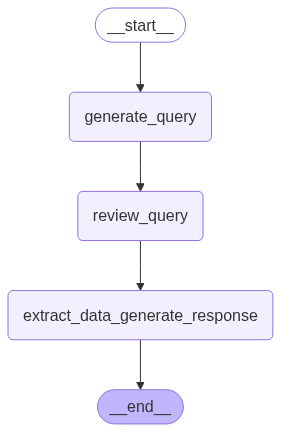

In [ ]:
from IPython.display import Image, display

# compile the graph
runnable = graph.compile()

# Now display as Mermaid diagram PNG
display(Image(runnable.get_graph().draw_mermaid_png()))


In [ ]:

# --------------- Step 6: Run Example ----------------

user_question = "Show me the names and salaries of employees in the Engineering department having salaries more than company average."

final_state = runnable.invoke({"question": user_question})

print("Final Respose:")
print(final_state['response'])

Final Respose:

This query shows the names and salaries of employees in the Engineering department who have a salary higher than the average salary of all employees. The results list Alice and Diana with salaries of 90000 and 95000 respectively. It is recommended to use a JOIN instead of a nested SELECT statement for better efficiency and readability.


In [ ]:
print("Generated SQL Query:")
print(final_state["generated_sql"])
print("\nReviewed and Improved SQL Query:")
print(final_state["improved_sql"])

Generated SQL Query:

SELECT name, salary
FROM employees
WHERE department = 'Engineering' AND salary > (SELECT AVG(salary) FROM employees)

Reviewed and Improved SQL Query:

-- The query looks correct, but it can be improved by using a JOIN instead of a nested SELECT statement. This would make the query more efficient and easier to read. 

SELECT name, salary
FROM employees
INNER JOIN 
(SELECT AVG(salary) AS avg_salary FROM employees) AS avg_emp
ON employees.salary > avg_emp.avg_salary
WHERE department = 'Engineering'


In [ ]:
## End